<a href="https://colab.research.google.com/github/nadyayal/CRM/blob/main/CRM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
def read_adas4(adas4_file, add_process_type, ):
  with open(adas4_file) as file:
    array = [row.strip() for row in file]
  line_num = []
  for i in range(len(array)):
    if array[i] == '-1':
      line_num.append(i)

  z1 = [i.split()[:] for i in array[(2):line_num[0]]] #read configuration data, energy cm-1
  df1 = pd.DataFrame(z1[:])
  l = []
  for i in range(len(z1)):
    l.append(str(z1[i][3]+z1[i][4]))
  df1[7] = l
  df1 = df1.drop({1,3,4,6}, axis=1)
  df2 = pd.DataFrame(data = {'Level_i': ['1'],  'Configuration': ['1S1'] , 'Energy': ['0'], '(2S+1)L(J)': ['(1)0(0.0)']}) #data for i = 1
  df1 = df1.rename(columns={0: 'Level_i', 2: 'Configuration', 5: 'Energy', 7: '(2S+1)L(J)'})
  df_conf = pd.concat([df2, df1]).reset_index().drop(['index'], axis=1) # got config dataset
  df_conf['Energy'] = df_conf['Energy'].astype(float)
  df_conf['Energy_eV'] = [i*h*c for i in df_conf.Energy[:]] #transfering energy to eV
  df_conf = df_conf.drop(['Energy'], axis=1)

  degen = []
  for i in df_conf['(2S+1)L(J)']:
    symb = []
    for j in range(len(i)):
      if i[j] == '(':
        symb.append(j)
    degen.append(2*float(i[symb[1]+1:-1])+1) #2J+1 https://mipt.ru/dmcp/student/sc_work/Kostykevich_220508.pdf
  df_conf['degeneracy'] = degen

  z = [i.split()[:] for i in array[(line_num[0]+2):line_num[1]]] #read coef data
  for i in range(len(z)):
    for j in range(len(z[i])):
      if z[i][j] != '+1':
        if '+' in z[i][j]:
          z[i][j] = z[i][j].replace('+', 'e+')
        elif '-' in z[i][j]:
          z[i][j] = z[i][j].replace('-', 'e-')
  df = pd.DataFrame(z[:])

  df_pr = df.loc[df[0] == add_process_type]
  df = df.loc[df[0] != add_process_type]
  if add_process_type == 'S':
    df = df.drop([17], axis = 1)

  cols = ['Level_j', 'Level_i', 'A3', '1.16+04', '2.32+04', '5.80+04', '1.16+05',
        '2.32+05', '5.80+05', '1.16+06', '2.32+06', '5.80+06', '1.16+07',
        '2.32+07', '5.80+07', '1.16+08', '2.32+08']

  eV = 8.61732814974056E-05
  l = ['Level_j', 'Level_i', 'A3']
  for i in cols:
      if '+' in i:
          l.append(str(round(literal_eval(str(i).replace('+', 'e+'))*eV,6)))
  for i in range(len(l)):
      df = df.rename(columns={i : l[i]})
  df.iloc[:,2:] = df.iloc[:,2:].astype(float)
   
  df_pr = df_pr.rename(columns={0:'pr_type'})
  
  Aik = df['A3']
  
  df = df.drop(['A3'], axis=1)
  l.remove('A3')
  for i in range(len(l)):
    df_pr = df_pr.rename(columns={i+1: l[i]})
  df_pr = df_pr.drop(['Level_i'], axis=1)
  df_pr = df_pr.rename(columns={'Level_j': 'Level_i'})
  '''if add_process_type == 'S':
    df_pr = df_pr.drop(['A3'], axis=1)'''
  df_pr.iloc[:,2:] = df_pr.iloc[:,2:].astype(float)

  return df, df_pr, Aik, df_conf


def plot_coef_temp(df, idx): #idx - index depending on process
  temp_range = [] #dependence on Temp

  for i in df.columns[2:]:
    temp_range.append(float(i))
  coef_range = []

  if df.columns[0] == 'pr_type':
    if df.pr_type[idx] == 'R':
      ttl = 'Free electron recombination'
      cols_to_drop = ['pr_type', 'Level_i']
    elif df.pr_type[idx] == 'S':
      ttl = 'Ionisation'
      cols_to_drop = ['pr_type', 'Level_i']
  else:
    ttl = 'Free electron excitation'
    cols_to_drop = ['Level_i', 'Level_j']
 
  for i in df.drop(cols_to_drop, axis=1).loc[idx]:
    coef_range.append(float(i))

  plt.scatter(coef_range, temp_range)
  plt.xlabel('Coefficient')
  plt.ylabel('Temperature')
  plt.title(f'{ttl} rate coefficient dependence on Te')
  plt.show()
  return temp_range, coef_range

def matrix_cacl(Te, lvl_i, df_conf):
  Uex_Te = df_ex[{'Level_j'	, Te}].loc[df_ex.Level_i == lvl_i] #df for Te with Level_i col
  rec_coef_df, ion_coef_df = df_r[{'Level_i'	, Te}], df_i[{'Level_i'	, Te}]

  idx = df_ex.loc[df_ex.Level_i == lvl_i].index #for Einst coef Aji

  qji = const/df_config['degeneracy'][int(lvl_i):].reset_index(drop=True) * (
      IH/kB/float(Te1)*eV)**0.5 * Uex_Te[Te].reset_index(drop=True)
  dE = df_conf['Energy_eV'][int(lvl_i):]-df_conf['Energy_eV'][int(lvl_i)-1]
  exp_calc = np.exp(dE/kB/float(Te)*eV)
  factor = df_conf['degeneracy'][int(lvl_i):] / df_conf['degeneracy'][int(lvl_i)-1] * exp_calc
  qij = factor.reset_index(drop=True) * qji

  Si = ion_coef_df[Te].loc[ion_coef_df.Level_i==lvl_i]
  Cii = ne*float(Si) + sum(ne*qij)
  Cij = Aji[idx].reset_index(drop=True)+ne*qji #?

  return Cii, Cij, qij, qji, Si

In [3]:
#const
ion_potential = 198310.8
eV = 8.61732814974056E-05
h = 4.135667669e-15 #eV*s
c = 29979245800 #cm/s

const = 2.1716e-8 #cm3 s-1 #for excitation rate coef
IH = 13.6048 #eV
kB = 8.617e-5 #eV/K

In [4]:
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [5]:
df_ex, df_i, Aji, df_config = read_adas4("/content/drive/MyDrive/CRM_data/helike_hps02he.dat", 'S')
_, df_r, _, _ = read_adas4("/content/drive/MyDrive/CRM_data/helike_kvi97#he0.dat", 'R')

In [7]:
ne = 1e13 # Electron density in cm**-3
ni = 2e13 # Ion density in cm**-3

Te1 = '49.980503'
lvl_i = '14'

In [8]:
Cii, Cij, qij, qji, Si = matrix_cacl(Te1, lvl_i, df_config)

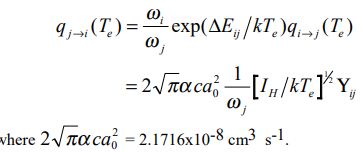

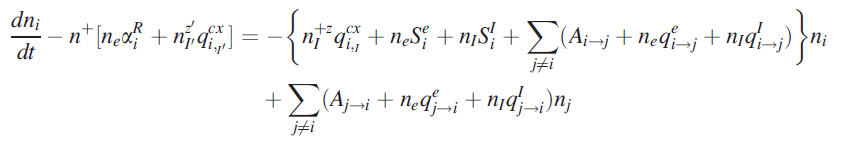

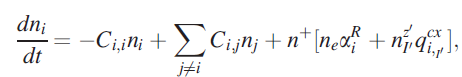

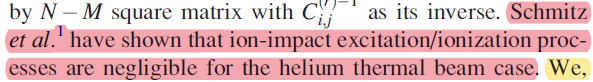

thats why we don't include qI , SI.
Our ionization coeff is "electron impact ionisation data to stage above"

In [10]:
Te=Te1
df_conf = df_config

In [11]:
Uex_Te = df_ex[{'Level_j'	, Te}].loc[df_ex.Level_i == lvl_i] #df for Te with Level_i col
rec_coef_df, ion_coef_df = df_r[{'Level_i'	, Te}], df_i[{'Level_i'	, Te}]

idx = df_ex.loc[df_ex.Level_i == lvl_i].index #for Einst coef Aji

qji = const/df_config['degeneracy'][int(lvl_i):].reset_index(drop=True) * (
  IH/kB/float(Te1)*eV)**0.5 * Uex_Te[Te].reset_index(drop=True)
dE = df_conf['Energy_eV'][int(lvl_i):]-df_conf['Energy_eV'][int(lvl_i)-1]
exp_calc = np.exp(dE/kB/float(Te)*eV)
factor = df_conf['degeneracy'][int(lvl_i):] / df_conf['degeneracy'][int(lvl_i)-1] * exp_calc
qij = factor.reset_index(drop=True) * qji

Si = ion_coef_df[Te].loc[ion_coef_df.Level_i==lvl_i]
Cii = ne*float(Si) + sum(ne*qij)
Cij = Aji[idx].reset_index(drop=True)+ne*qji #?



In [12]:
Uex_Te = df_ex[{'Level_i', 'Level_j'	, Te}].loc[(df_ex.Level_i == lvl_i) | (df_ex.Level_j == lvl_i)]

In [13]:
qji = const/df_config['degeneracy']* (
  IH/kB/float(Te1)*eV)**0.5 * Uex_Te[Te].reset_index(drop=True)

In [14]:
l = []
lvl = 1
for i in Uex_Te.index:
  l.append(const/int(df_config['degeneracy'].loc[df_config['Level_i'] == str(lvl)].values) * (IH/kB/float(Te1)*eV)**0.5 * Uex_Te[Te][i])
  lvl = lvl + 1
  if lvl == int(lvl_i):
    lvl = lvl + 1

In [15]:
qji = pd.Series(l, index=Uex_Te.index)

In [16]:
df_config['Energy_eV'].loc[df_config['Level_i'] == str(int(lvl_i)+1)] - df_config['Energy_eV'].loc[df_config['Level_i'] == lvl_i]

13   NaN
14   NaN
Name: Energy_eV, dtype: float64

In [17]:
df_config['Energy_eV'].loc[df_config['Level_i'] == lvl_i]

13   2.37e+01
Name: Energy_eV, dtype: float64

In [18]:
qji

12    4.37e-11
29    5.36e-09
45    1.95e-10
60    8.85e-09
74    2.50e-10
87    8.72e-08
99    4.85e-10
110   1.91e-07
120   6.80e-08
129   1.02e-08
137   5.06e-10
144   3.66e-05
150   1.53e-09
156   1.98e-05
157   1.16e-09
158   3.22e-07
159   7.20e-10
160   1.78e-09
dtype: float64

In [19]:
df_config['degeneracy'].loc[df_config['Level_i'] == ind_i]

NameError: ignored

In [ ]:
df_config['degeneracy'][int(lvl_i):]

In [ ]:
Uex_Te['Level_j'][12]

In [ ]:
df_config['degeneracy']

In [ ]:
data_nist

In [ ]:
data_nist = pd.read_excel('/content/drive/MyDrive/CRM_data/data_nist.xlsx').drop(['Acc'], axis=1)
for i in data_nist['Aki(s^-1)'].index:
  if data_nist['Aki(s^-1)'][i] == '  ':
    data_nist['Aki(s^-1)'][i] = '0'
data_nist['Aki(s^-1)'], data_nist['Ei(eV)'], data_nist['Ek(eV)'], data_nist['obs_wl_vac(nm)'] = data_nist[
    'Aki(s^-1)'].astype(float), data_nist['Ei(eV)'].astype(float), data_nist['Ek(eV)'].astype(float), data_nist[
    'obs_wl_vac(nm)'].astype(float)
data_nist['g_i'], data_nist['g_k'] = data_nist['g_i'].astype(int), data_nist['g_k'].astype(int)

In [ ]:
data_nist